# [ 시계열 분석 Main Quest ]

1. Data Labeling
2. Feature Engineering
3. Model Training

# 1. Data Labeling
① Price Change Direction 적용하기

② 이동평균(Moving Average) 적용하기

③ Local Min-Max 적용하기

④ Trend Scanning 적용하기

- 데이터 라벨링
    - 원본 데이터에 추가적인 정보를 부여하는 과정
    - 각 데이터 포인트가 어떤 상태나 범주에 속하는지 나타냄
    - 데이터를 더 유의미하게 만들고 분석의 정확성 높일 수 있음
    - ex. 주식 가격 데이터에 '상승/하락' 등의 라벨링 -> 주가변동 패턴 분석 및 예측에 활용


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:xlabel='time'>

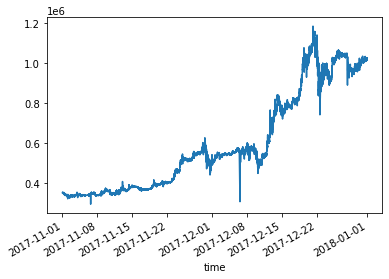

In [2]:
# 데이터 경로
DATA_PATH = '/aiffel/aiffel/fnguide/data/'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

In [ ]:
modify_data.head()

## 1-1. Price Change Direction 적용하기
[to-do]
- momentum_signal 만들기 (window 사용하여 현재와 특정 기간 이전의 종가 차이 구하기)
- 기존 데이터(modify_data)와 수식이 적용된 데이터(momentum_signal) 시각화하여 차이 비교

### (참고) price change direction 
- 개념: 가격 변화의 방향을 기준으로 라벨링
- 특징: 간단, 상승&하락 두가지로 라벨링(이진분류), 단기 예측에 유용
- 수식: df['close'].shift(window)

In [3]:
# window 지정 (10일간의 데이터 기반으로 계산 세팅)
window = 10

# momentum_signal 만들기
# modify_data의 close열(주식종가) 가져와서 10일 전의 데이터와 차이 구하기
# np.sign: 변화량이 양수면 1, 음수면 -1, 없으면 0 반환
# 주가 상승/하락만 단순 파악 위하여 위 식에 +1 더하고 한 번 더 np.sign 적용 (-> 결과 : 0 또는 1)
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)

# s_momentum_signal 만들기
# 위 momentum_signal을 판다스 시리즈 객체로 변환
# 기존 데이터인 modify_data와 동일한 index로 맞추어 신호가 언제 발생했는지 쉽게 매칭 및 추가 분석 가능하도록 세팅
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

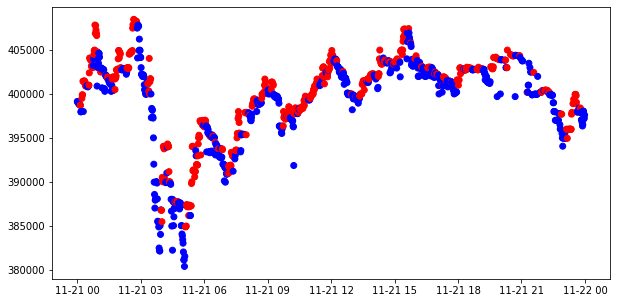

In [4]:
# 기존 데이터 만들기
# loc을 활용해서 modify_data 데이터프레임의 2017년 11월 21일 종가 데이터 추출 및 sub_data로 저장
sub_data = modify_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
# s_momentum_signal 시리즈에서 2017년 11월 21일의 시간대별 모멘텀 신호 값 추출  및 c_sig로 저장
c_sig = s_momentum_signal.loc['2017-11-21']

# 두 데이터의 비교를 위한 색상 바꾸기
# c_sig가 1이면 red, 아니면 blue로 'color'라는 새로운 컬럼 추가
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue') # np.where 사용

# 시각화하기
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])
# 특정 날짜의 종가 데이터를 모멘텀 신호에 따라 색상으로 표시
# x축 = sub_data의 인덱스 = 날짜
# y축 = sub_data = 종가 데이터
# c = 점의 색상

## 1-2. Using Moving Average 적용하기
- 개념: 이동평균을 기준으로 현재 가격이 이동평균보다 높은지(1)/낮은지(-1) 라벨링
    - 이동평균: 일정 기간 동안의 평균 가격을 계산하여 추세 파악에 사용
- 특징: 
    - 단기 변동성 제거하고 장기 추세 분석 가능
    - 이동 평균을 통해 데이터 노이즈 줄이고 더 명확한 추세 확인 가능(평활화)
    - 단기, 중기, 장기 등 다양한 기간으로 이동평균 활용 가능
- 수식: df['close'].rolling(window=3).mean()

In [5]:
# momentum_signal
# modify_data['close'].rolling(window).mean() 활용
# modify_data 데이터프레임의 close열(종가) 가져와서 지정된 window만큼 이동평균 계산(rolling)
# window=10이므로 최근 10일간의 종가 평균 계산
# 현재 종가에서 10일 이동평균 뺀 값을 계산하여 양수1, 음수-1, 0이면 0 반환
# 위 값에 1을 더해서 종가가 이동평균보다 작다면 0, 같거나 크다면 1 반환
# 즉, momentum_signal은 주가가 이동평균보다 높으면 1, 낮으면 0을 나타내는 신호
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1) 

# s_momentum_signal
# 위의 momentum_signal을 판다스 시리즈 객체로 변환 및 기존 데이터프레임의 인덱스(날짜) 유지
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

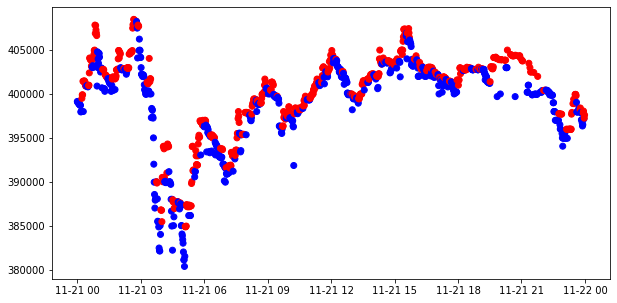

In [6]:
# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

# 시각화하기
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

## 1-3. Local Min-Max 적용하기
- 개념: 국지적 최소값과 최대값 기준 라벨링
- 특징:
    - 국지적 극단값 식별
    - 트렌드 변화 감지
    - 맞춤형 기간

In [7]:
# Local min / max 를 추출하기 위한 함수 정의 (wait은 최소/최대값 업데이트를 위한 최소 일수)
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]     # 첫번째 종가 값으로 초기화
    max_value = close.iloc[0] # ①
    n_cnt_min, n_cnt_max = 0, 0     # 로컬 최솟값과 최댓값 찾기 위해 지난 일수 카운트
    
    mins, maxes = [], []     # 최솟값, 최댓값 저장할 리스트
    min_idxes, max_idxes = [], []     # 최솟값, 최댓값의 인덱스를 저장할 리스트
    b_min_update, b_max_update = False, False     # 최솟값, 최댓값 업데이트 여부 나타내는 불리언 변수
    
    
    # 종가 데이터의 첫 번째 값을 제외한 나머지 값들에 대해 반복
    # idx = 인덱스(날짜), val = 종가 값을 나타냄.
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:      
            min_value = val     # 현재 값 val이 min_value보다 작으면 min_value를 val로 업데이트
            mins.append(min_value)     # mins 리스트에 min_value 추가
            min_idxes.append(idx)     # min_idxes 리스트에 인덱스 idx 추가
            n_cnt_min = 0     # n_cnt_max를 0으로 초기화
            b_min_update = True      # b_min_update를 True로 설정
        if val > max_value:
            max_value = val # ②
            maxes.append(max_value)  # ③
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True # ④
        
        if not b_max_update:     # 최댓값이 업데이트 되지 않은 경우
            b_min_update = False     # b_min_update를 False로 설정
            n_cnt_min += 1     # n_cnt_min을 1 증가
            if n_cnt_min >= wait:     # n_cnt_min이 wait 값보다 크거나 같으면
                max_value = min_value     # max_value를 min_value로 업데이트
                n_cnt_min = 0     # n_cnt_min을 0으로 초기화
    
        if not b_min_update:
            b_max_update = False # ⑤
            n_cnt_max += 1 # ⑥
            if n_cnt_max >= wait:
                min_value = max_value # ⑦
                n_cnt_max = 0
    
    # mins와 min_idxes를 사용해 로컬 최솟값과 그 인덱스를 담은 데이터프레임 생성.
    # maxes와 max_idxes를 사용해 로컬 최댓값과 그 인덱스를 담은 데이터프레임을 생성.
    # 두 데이터프레임 반환.          
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes}) # ⑧

### (참고) 다양한 최댓값 추출 이유
- 변동 패턴 이해 및 변곡점 확인
- 추세 분석 (얼마나 자주 변동하는지, 각 변동이 얼마나 큰지 파악)
- 지지선&저항선 확인하여 적절한 매수/매도 시점 파악
- 리스크 관리 (특정 가격 수준에서 주가가 어떻게 반응하는지 확인)

In [8]:
# Local mins, maxes를 확인
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인 
print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

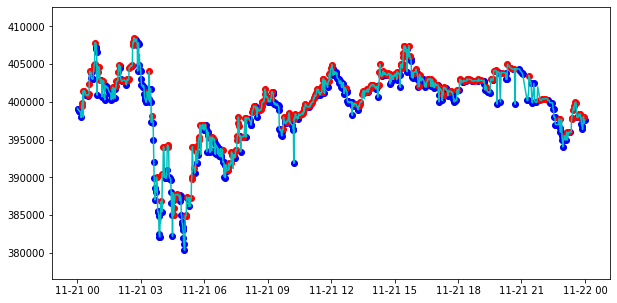

In [9]:
# subplots 및 plot 생성
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# sub_data를 선 그래프로 표시. c는 선색상 cyan(청록색)
ax.plot(sub_data, 'c')

# min_time, local_min을 활용한 scatter plot 생성
# 로컬 최솟값을 점으로 표시.
# x축은 날짜(시간) 인덱스, y축은 해당 날짜의 로컬 최솟값
ax.scatter(mins.min_time, mins.local_min, c='blue')

# maxes_time, local_max를 활용한 scatter plot 생성
ax.scatter(maxes.max_time, maxes.local_max, c='red')

# y축 범위 설정
# sub_data.min 값보다 1% 낮은 값 ~ max보다 1% 높은값까지
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

## 1-4. Trend Scanning 적용하기
- 개념: 트렌드를 스캔하여 특정 기간 동안의 가격 변동 추세 라벨링
- 특징:
    - 추세 분석: 일정 기간 동안의 가격 변동 추세 분석
    - 장기 예측: 장기적인 추세를 파악하고 예측하는 데 유용
    - 다양한 분석 기법: ex. 이동평균 교차, 회귀 분석 등

In [10]:
# t-value 계산 함수 정의

def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend : 선형회귀 분석에서 사용할 독립 변수 행렬 생성 
    # (*선형회귀 분석은 데이터의 관계를 분석하는 통계 기법, 주어진 데이터로부터 추세를 찾고 모델링하는데 사용)
    # 행의 수가 close데이터 포인트 수와 같고, 열의 수가 2인 배열 x생성
    # (선형 회귀 분석에서는 '절편'과 '기울기' 추정. 이를 위해 두 개의 독립 변수 필요하여 열을 2개 만드는것)
    # np.ones를 통해 배열의 모든 값은 1로 초기화
    x = np.ones((close.shape[0], 2))
    
    # x의 첫 번째 열은 절편을 위한 값으로 모두 1로 채운채로 냅둠.(그렇게 하므로써 회귀 모델에 y절편 포함시킬 수 있음)
    # x의 두 번째 열을 0부터 close.shape[0]까지의 정수로 채우기
    # 두번째열은 '시간 변수' 나타냄. 데이터 포인트가 시간의 흐름에 따라 정수로 증가.    
    x[:, 1] = np.arange(close.shape[0])
    
    # ols 회귀모델 생성
    # close는 종속변수로 주어진 시계열 데이터, x는 독립변수로 앞서 생성한 행렬 사용
    # fit으로 회귀모델 학습 및 적합    
    ols = sml.OLS(close, x).fit()
    
    # 회귀 모델 결과로부터 t-value 추출 및 반환
    # [1]은 두 번째 열(시간변수)에 대한 t-value
    return ols.tvalues[1]

In [11]:
# 변수 설정

# 각 시점에서 분석할 데이터의 길이
look_forward_window = 60

# 분석에 사용할 최소 데이터 길이
min_sample_length = 5

# 데이터 분석 시 이동할 스텝 크기
step = 1

# 저장할 결과를 위한 빈 리스트
t1_array = []
t_values_array = []

In [12]:
# 이 코드 블럭은 실행에 20-30분정도가 소요될 수 있습니다.
# 특정 날짜에 대해 일정 기간 동안의 주식 변동성 분석 및 그 결과를 label 데이터프레임에 저장

# modify_data에서 지정 기간의 인덱스 가져오기
molecule = modify_data['2017-11-01':'2017-11-30'].index

# molecule을 인덱스로 하는 빈 데이터프레임 생성. t1, t_val, bin이라는 컬럼 포함
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])

# 임시 결과 저장할 빈 리스트
tmp_out = []


# molecule의 각 인덱스(날짜)에 대해 반복문 실행 및 진행 상황 시각화(tqdm)
for ind in tqdm(molecule):
    # 현재 날짜(인덱스) ind부터 look_forward_window까지 길이만큼의 'close(종가)'데이터 가져와서 subset에 저장
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    # subset의 데이터가 look_forward_window보다 짧으면 이 인덱스 건너뛰기
    if look_forward_window > subset.shape[0]:
        continue
    
    # subset의 일정 길이 범위에서 t-value 계산할 빈 시리즈 생성
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    
    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    # min_sample_length부터 subset 길이까지 반복문 실행. 각 구간에 대한 t-value 계산
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        # 각 구간에 대해 t_val_lin_r 함수 호출하여 t-value 계산 및 tval 리스트에 저장
        tval.append(t_val_lin_r(df.values))  # t-value 사용
    
    # 계산한 t-value를 tmp_subset에 저장
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    # tmp_subset에서 무한대나 NaN값을 0으로 대체하고, 절댓값을 취한 후 최대값의 인덱스 찾기
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    # 최대 t-value를 찾고 tmp_t_val에 저장   
    tmp_t_val = tmp_subset[idx_max]
    # tmp_subset의 마지막 인덱스(날짜), 최대 t-value, t-value의 부호를 리스트에 저장
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

# label 데이터프레임에 tmp_out 결과 추가
label.loc[molecule] = np.array(tmp_out)  # prevent leakage

# t1열의 값을 날짜/시간 형식으로 변환
label['t1'] = pd.to_datetime(label['t1'])

# bin열의 값을 정수형으로 변환
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [13:46<00:00, 40.40it/s]


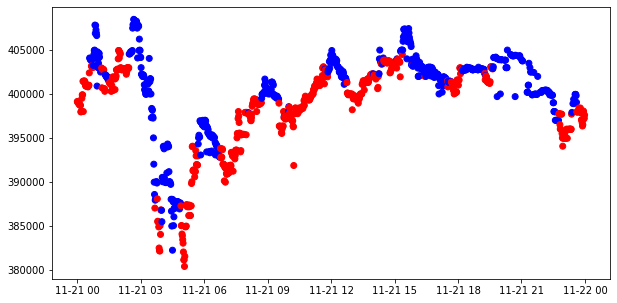

In [13]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

-------------------------------------------------------------------

# 2. Feature Engineering

- 개념: 도메인 지식을 활용하여 정제되지 않은 원본 자료를 탐색과 분석, 가공을 거쳐 특성 추출 및 특성 선택하는 것
- Feature 선택 방법:
    - Filter Method: 피처들의 연관성 찾는 방식
    - Wrapper Method: 해결하고자 하는 문제에 대한 유용성을 측정하는 방식(validation set에서 성능이 최대화 되는 피처세트 선정)
    - Embedded Method: 훈련 알고리즘에 피처 선정 과정이 포함되는 방식(라쏘, 릿지, 엘라스틱넷 등)


### 실습 순서
① 환경구성 및 데이터 불러오기

② Technical Index 적용하기

③ Feature Selection methods 적용하기

## 2-1. 환경 구성 및 데이터 불러오기

In [14]:
!pip install ta==0.9.0
!pip install shap

In [15]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [16]:
# 데이터 경로 설정
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져오기
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

In [ ]:
# 데이터 확인
df_sub_modify_data.head()

In [ ]:
df_label_data.head(), df_label_data.tail()

In [ ]:
df_label_data.value_counts()

## 2-2. Technical Index 적용하기

- 기술적 지표: 시장의 주가 또는 거래량 데이터를 기반으로 주가의 향방 예측을 위해 고안된 지표
- 적용 이유: 추세 파악, 과매수/과매도 상태 확인, 변동성 측정, 모멘텀 분석
- 장점: 단순성, 시각적 명확성, 다양한 응용 가능성
- 단점: 과거 데이터 의존성, 노이즈 포함, 과최적화 위험


### (1) 추세 지표
- MACD (Moving Average Convergence/Divergence) : 단기 이평선과 장기 이평선의 차이로 주가의 수렴/확산 정도를 나타내는 지표, 'signal', 'average', 'diverence'로 구성.
- ADX (Average Directional Movement) : 금일의 주가 움직임의 범위가 전일의 범위를 어느 방향으로 벗어났는지를 관찰, 추세의 강도를 추적하는 지표
- TRIX (Triple Exponential) : n-영업일 지수가중평균을 3번 연달아 실시한 후, 그 값의 기울기를 나타낸 지표
- DPO (detrended price oscillator) : 가장 최신의 가격 흐름에 반응하지 않도록 변위된 이동평균을 사용하여, 장기추세를 제거하기 위한 지표. 중기 과매수 / 과매도 정도를 표시
- AROON : 추세의 강도와 변화를 식별하기 위한 지표, 고가사이의 시간차와 저가사이의 시간차를 측정

### (2) 변동성 지표
- ATR (Average True Range) : 시장의 변동성을 측정하기 위한 지표, (고가 - 저가), (고가 - 전일종가)의 절대값, (저가 - 전일종가)의 절대값 중 큰값을 취하여, 이동평균
- UI (Ulcer Index) : 가격 하락의 유지기간, 깊이를 통해 가격의 하락 위험을 측정하는 지표

### (3) 거래량 지표
- CMF (Chaikin Money Flow) : 산출방식이 MACD와 유사, 두 accumulation/distribution line의 EMA값의 차이를 통해 돈의 유입/유출을 파악하려는 지표
- MFI (Money Flow Index) : 가격의 흐름과 거래량의 조합으로 모멘텀의 방향성을 나타내는 지표
- FI (Force Index) : 가격과 거래량을 사용하여 가격의 움직임을 좌우하는 힘의 강도를 측정하는 지표
- SMA EM (Ease of Movement) : 가격의 상승/하락을 판단하기 위한 지표. 가격의 변동성과 거래량을 통해 가격 흐름의 용이성을 측정
- VPT (Volume Price Trend) : 가격의 변화 강도와 그 방향을 나타내는 지표. 수요 / 공급의 균형을 측정

### (4) 모멘텀 지표
- RSI (Relative Strength Index) : 가격 흐름의 상대강도를 측정하는 지표. 일정기간 내의 평균 수익과 손실의 강도를 비교함.
- WR (Williams %R) : 과매도 / 과매수를 측정하는 지표(-100 ~ 0). 진입 / 청산 시점을 포착하는데 사용됨.

In [17]:
# 다양한 기술적 지표 적용

mt = 1     # 시간창 조절을 위한 변수 세팅
fillna = False     # 결측값 채우지 않음
df_ = df_sub_modify_data.copy()     # 원본 데이터프레임 복사하여 df_로 저장
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]    # 데이터프레임의 열 이름 정의


## Volume Index (거래량 지표) 계산

# Chaikin Money Flow: 주가와 거래량을 함께 고려한 지표. 매수와 매도의 압력 측정
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()

# Force Index: 거래량과 가격 변동을 사용하여 시장의 힘 측정
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()

# Money Flow Indicator: 주가와 거래량을 함께 고려하여 과매수 및 과매도 상태 측정
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()

# Ease of Movement: 주가의 이동성과 거래량을 결합한 지표로 주가의 움직임이 얼마나 쉽게 이루어지는지 측정
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend: 주가와 거래량을 사용하여 가격 추세 분석
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()


## volatility index(변동성 지표) 계산

# Average True Range: 주가의 변동성 측정 지표
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index: 주가의 하락 리스크 측정
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()


## trend index(추세 지표) 계산

# MACD: 두 개의 이동 평균선을 사용하여 주가의 추세 분석
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX): 주가의 추세 강도 측정
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator: 주가의 변동성 나타내는 지표로 추세의 방향 분석
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index: 주가의 반전 가능성
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator: 주가의 주기적인 변동 분석
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator: 주가의 추세 식별
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()


## momentum index(모멘텀 지표) 계산
# Relative Strength Index (RSI): 주가의 과매수와 과매도 상태 분석
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator: 주가의 과매수 및 과매도 상태 측정
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [18]:
# 수익률 / 변동성 계산
# 변수 정의
windows_mom = [5, 10, 20]     # 수익률 모멘텀을 계산할 창의 크기 정의(5,10,20일 간격으로 수익률 계산)
windows_std = [30]     # 변동성 계산할 창 크기 정의 (30일 동안의 변동성 계산)

for i in windows_mom:
    # i일간의 백분율 변화 계산해서 소수점 6자리까지 반올림하여 새로운 열에 저장
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    # i일간(30일)의 종가&거래량의 표준 편차 계산하여 새로운 열에 저장
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [19]:
# 데이터 병합 및 모델 훈련
# 기술적 지표를 계산한 df_와 기존 df_label_data 병합하고 결측값 제거
df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1] 
y = df_tmp_data.iloc[:, -1]

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [20]:
# RandomForest 모델 적용
rfc = RandomForestClassifier(class_weight='balanced')

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

## 2-3. Feature Selection methods 적용하기

In [21]:
# MDI, Mean Decrease Impurity 
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.050141,0.002558
volume_fi,0.041139,0.002225
volume_mfi,0.046359,0.002434
volume_sma_em,0.036665,0.002023
volume_vpt,0.023387,0.001279
volatility_atr,0.079078,0.003046
volatility_ui,0.050470,0.002543
trend_macd_diff,0.076835,0.004359
trend_adx,0.052739,0.002072
trend_trix,0.071549,0.003110


In [22]:
# MDA, Mean Decrease Accuracy
svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
cv = KFold(n_splits=5) # n_splits을 변경해봅시다.
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [23]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

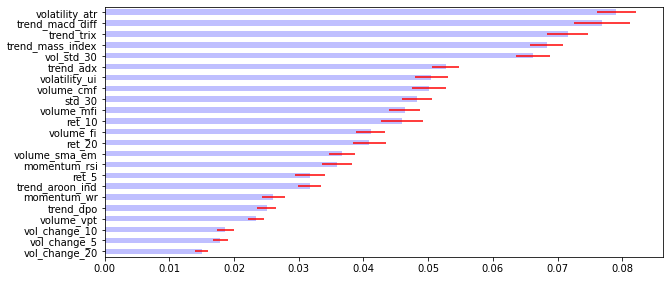

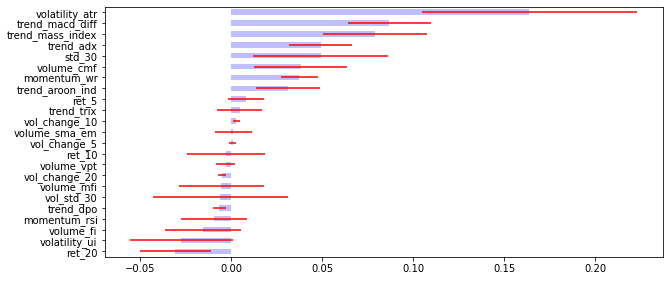

In [24]:
# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

In [25]:
# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True) 
rfe_cv = RFECV(svc_rbf, cv=cv) # RFECV
rfe_fitted = rfe_cv.fit(X_sc, y) # fit

In [26]:
# 선택된 피쳐 확인하기
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})

rfe_df[rfe_df["Optimal_Features"]==True]

,Optimal_Features,Ranking
volatility_atr,True,1
trend_macd_diff,True,1
std_30,True,1


In [27]:
# SFS, Sequential Feature Selection

n = 2
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [28]:
# 선택된 피쳐 확인하기

sfs_rank = sfs_fitted.get_support()
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns={"Optimal_Features"})

sfs_df [sfs_df ["Optimal_Features"]==True].index

Index(['volume_mfi', 'trend_macd_diff'], dtype='object')

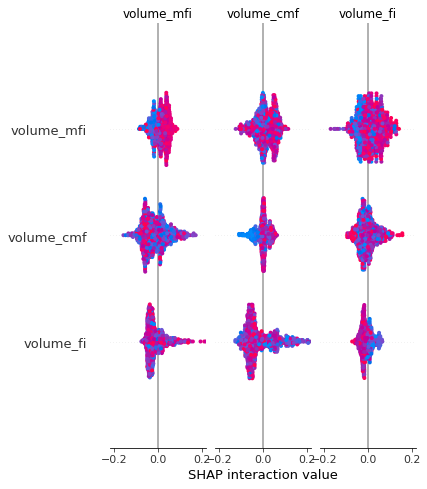

In [29]:
# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap.summary_plot(shap_value, X_sc)

# 3. Model Training

① 환경구성 및 데이터 불러오기

② Purged K-fold for Cross-Validation적용하기

③ Model 적용하기

## 3-1. 환경 구성 및 데이터 불러오기

In [30]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

In [32]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

## 3-2. Purged K-fold for Cross-Validation적용하기

In [33]:
# 교차검증 횟수 정의
# 4부터 +-1씩 진행해보려 했으나 시간 관계상 5밖에 못함...
n_cv = 5

t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold 
cv = PKFold(n_cv, t1, 0)

## 3-3. Model 적용하기

In [34]:
# GridsearchCV에서 사용할 파라미터 설정
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'base_estimator__max_depth': [3,5,10,20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

In [35]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

In [36]:
# Bagging 적용
bag_rfc = bag_rfc = BaggingClassifier(rfc)

In [37]:
# GridSearchCV 적용
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)

In [38]:
# 하단 부분 돌리다가 시간 다되서 멈춤....ㅠㅠ

# fit
gs_rfc.fit(train_x, train_y)

# best estimator 
gs_rfc_best = gs_rfc.best_estimator
gs_rfc_best.fit(train_x, train_y)

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator'

In [ ]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [ ]:
# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y) 
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

In [ ]:
# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')